In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm

def plotLoss(losses):
    plt.figure(dpi=90)
    plt.plot(losses, label='Loss')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def displayImage(image, label):
        plt.imshow(image.numpy().squeeze().reshape(28,28), cmap='gray')
        plt.title(label)
        plt.axis('off')

def displaySamples(n, **rows):
    plt.figure(figsize=(20, 8))
    for i in range(n):
        j = 0
        for key, value in rows.items():
            plt.subplot(len(rows), n, i + n*j + 1)
            displayImage(value[i], key)
            j += 1
    plt.show()

def numberToOneHot(labels, num_classes):
    
    one_hot_labels = torch.zeros((labels.shape[0], num_classes)).to(labels.device)
    
    one_hot_labels.scatter_(1, labels.unsqueeze(1), 1)
    
    return one_hot_labels.to(device)

class ModelPersistence:
    @staticmethod
    def load(model):
        result = model().to(device)
        state_dict = torch.load(result.path)
        result.load_state_dict(state_dict)
        return result
    
    @staticmethod
    def save(model):
        torch.save(model.state_dict(), model.path)
        
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Lambda(torch.flatten)
])

batch_size = 64
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

In [3]:
class Encoder(nn.Module):
    def __init__(self, learning_rate = 0.001):
        super(Encoder, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),     
            nn.Linear(512, 256),
            nn.ReLU(),     
            nn.Linear(256, 128),
            nn.Sigmoid(),
        )

        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        self.path = 'data/encoder.pth'

    def forward(self, x):
        x = self.layers(x)
        return x
    
class Decoder(nn.Module):
    def __init__(self, learning_rate = 0.001):
        super(Decoder, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(),     
            nn.Linear(256, 512),  
            nn.ReLU(),     
            nn.Linear(512, 784),  
            nn.Sigmoid(),
        )

        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        self.path = 'data/decoder.pth'

    def forward(self, x):
        x = self.layers(x)
        return x
    
class Denoiser(nn.Module):
    def __init__(self, learning_rate = 0.001):
        super(Denoiser, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),     
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.Sigmoid(),
        )
        
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        self.path = 'data/denoiser.pth'

    def forward(self, x):
        x = self.layers(x)
        return x

100%|██████████| 938/938 [00:05<00:00, 175.78it/s]


Epoch [1/10], Loss: 0.0297


100%|██████████| 938/938 [00:04<00:00, 198.97it/s]


Epoch [2/10], Loss: 0.0187


100%|██████████| 938/938 [00:04<00:00, 219.74it/s]


Epoch [3/10], Loss: 0.0175


100%|██████████| 938/938 [00:04<00:00, 203.29it/s]


Epoch [4/10], Loss: 0.0179


100%|██████████| 938/938 [00:04<00:00, 202.10it/s]


Epoch [5/10], Loss: 0.0129


100%|██████████| 938/938 [00:04<00:00, 192.93it/s]


Epoch [6/10], Loss: 0.0140


100%|██████████| 938/938 [00:05<00:00, 161.44it/s]


Epoch [7/10], Loss: 0.0103


100%|██████████| 938/938 [00:04<00:00, 196.19it/s]


Epoch [8/10], Loss: 0.0100


100%|██████████| 938/938 [00:04<00:00, 218.80it/s]


Epoch [9/10], Loss: 0.0095


100%|██████████| 938/938 [00:04<00:00, 222.13it/s]

Epoch [10/10], Loss: 0.0106


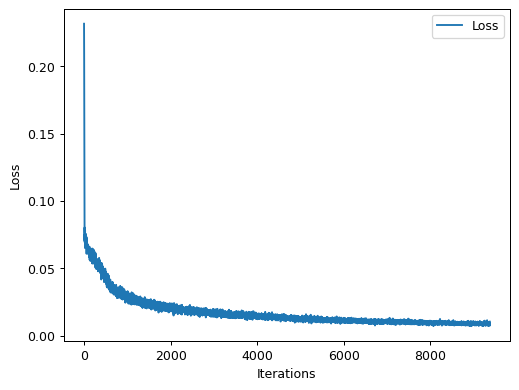

In [4]:
learning_rate = 0.001
epochs = 10

encoder = Encoder(learning_rate).to(device)
decoder = Decoder(learning_rate).to(device)
criterion = nn.MSELoss()

losses = []

for epoch in range(epochs):
    for data in tqdm(train_loader):
        
        images, _ = data

        images = images.to(device)

        encoder.zero_grad()
        decoder.zero_grad()
        
        encodedImages = encoder(images)
        outputs = decoder(encodedImages)

        loss = criterion(outputs, images)

        loss.backward()
        losses.append(loss.item())
        encoder.optimizer.step()
        decoder.optimizer.step()

    
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

ModelPersistence.save(encoder)
ModelPersistence.save(decoder)

plotLoss(losses)

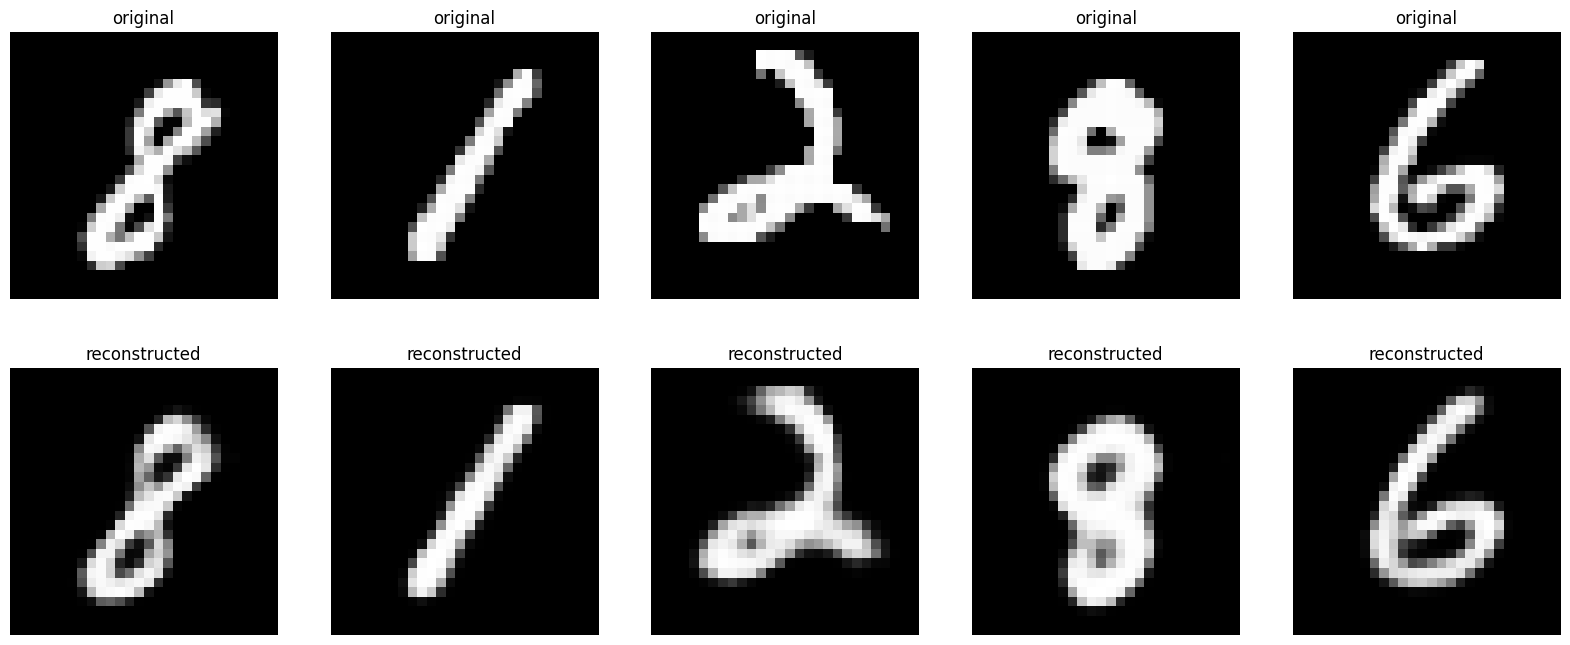

In [5]:
with torch.no_grad():
    test_images, _ = next(iter(train_loader))
    test_images = test_images.to(device)
    reconstructed_images = decoder(encoder(test_images))
    displaySamples(5, original=test_images.cpu(), reconstructed=reconstructed_images.cpu())

100%|██████████| 938/938 [00:04<00:00, 205.11it/s]


Epoch [1/10], Loss: 0.4144


100%|██████████| 938/938 [00:04<00:00, 210.87it/s]


Epoch [2/10], Loss: 0.4083


100%|██████████| 938/938 [00:04<00:00, 217.57it/s]


Epoch [3/10], Loss: 0.4100


100%|██████████| 938/938 [00:04<00:00, 210.90it/s]


Epoch [4/10], Loss: 0.4108


100%|██████████| 938/938 [00:04<00:00, 217.54it/s]


Epoch [5/10], Loss: 0.4080


100%|██████████| 938/938 [00:04<00:00, 227.78it/s]


Epoch [6/10], Loss: 0.4059


100%|██████████| 938/938 [00:04<00:00, 227.71it/s]


Epoch [7/10], Loss: 0.4011


100%|██████████| 938/938 [00:04<00:00, 220.61it/s]


Epoch [8/10], Loss: 0.4141


100%|██████████| 938/938 [00:06<00:00, 151.34it/s]


Epoch [9/10], Loss: 0.4139


100%|██████████| 938/938 [00:05<00:00, 168.41it/s]

Epoch [10/10], Loss: 0.4112


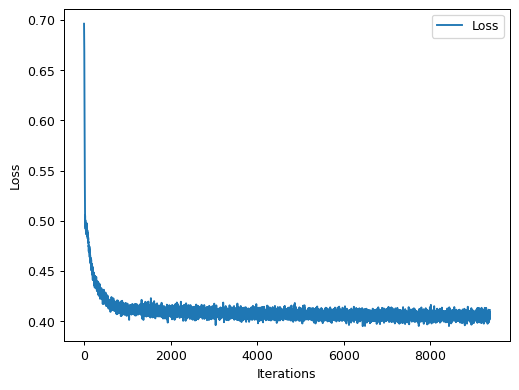

In [6]:
learning_rate = 0.001
epochs = 10

denoiser = Denoiser(learning_rate).to(device)
criterion = nn.BCELoss()

losses = []

for epoch in range(epochs):
    for data in tqdm(train_loader):
        
        images, labels = data
        oneHotLabels = numberToOneHot(labels,  10)
        images = images.to(device)
        denoiser.optimizer.zero_grad()
        
        encoded = encoder(images)
        noise = torch.randn_like(encoded) * 0.25
        dimEncoded = encoded * 0.75

        predicted = denoiser(dimEncoded + noise)
        loss = criterion(predicted, encoded)
        
        loss.backward()
        losses.append(loss.item())
        denoiser.optimizer.step()
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
    
ModelPersistence.save(denoiser)

plotLoss(losses)

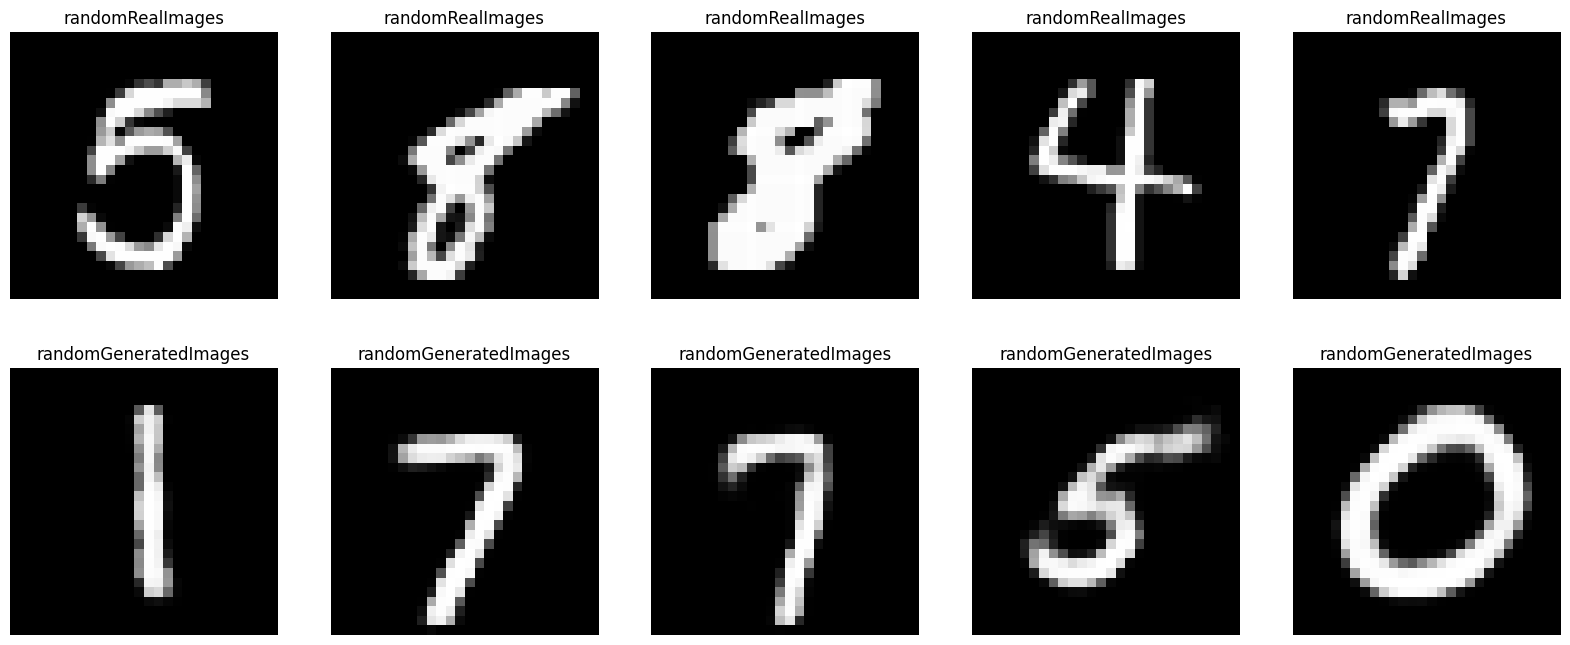

In [10]:
randomNoise = torch.randn((5, 128), device=device)

with torch.no_grad():
    
    test_images, _ = next(iter(train_loader))
    test_images = test_images.to(device)

    out = randomNoise
    for i in range(10):
        out = denoiser(out)

    generatedImages = decoder(out)

    displaySamples(5, randomRealImages=test_images.cpu(), randomGeneratedImages=generatedImages.cpu())

In [8]:
denoiser = ModelPersistence.load(Denoiser)
encoder = ModelPersistence.load(Encoder)
decoder = ModelPersistence.load(Decoder)

C:\Users\Thiago\AppData\Local\Temp\ipykernel_33224\1521150663.py:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(result.path)
